In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import sqlite3
from iminuit import Minuit
from scipy.stats import chi2
from ExternalFunctions import nice_string_output, add_text_to_ax

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('axes',  labelsize=20)
matplotlib.rc('font', **{'size'   : 18, 'family':'monospace'})
matplotlib.rcParams['figure.figsize'] = (12, 5)
matplotlib.rcParams['figure.titlesize'] = 22

all_dom_coordinates = pd.read_csv('/groups/icecube/debes/work/analyses/Efficiency/data/5083_DOM_coordinates_with_homemade_dom_id_from_burnsample.csv')
folder = '/groups/icecube/debes/work/analyses/Efficiency/data/burnsample_efficiency_reco/'

In [18]:
np.sum(mceff)**2 == np.sum(mceff**2)

False

In [19]:
def divide0(x,y):
#    return np.divide(x.astype(np.float32),   y.astype(np.float32),  out=np.zeros_like(y).astype(np.float32), where=y!=0)
    return np.divide(x, y, out=np.zeros_like(y), where=y!=0)

def divide0err(y1,y2, sigma_y1=None, sigma_y2=None):
    value = np.divide(y1, y2, where=y2!=0)

    if sigma_y1 is None:
        sigma_y1 = np.sqrt(y1)
    if sigma_y2 is None:
        sigma_y2 = np.sqrt(y2)

    error = value * np.sqrt((sigma_y1/y1)**2 + (sigma_y2/y2)**2)
    
    return value, error

def exponential(x, A, L, C):
        return A * np.exp(-x/L) + C

# Initial parameter 
A_init = 0.5
L_init = 40
C_init = 0.02

def fit_exp(y_data, y_err):
    def chi_square(A, L, C):
        y_model = exponential(x_data, A, L, C)
        return np.sum(((y_data - y_model) / np.array(y_err))**2)
    
    minuit = Minuit(chi_square, A=A_init, L=L_init, C=C_init)
    minuit.migrad()
    chi2_value = minuit.fval
    dof = len(x_data) - len(minuit.values)
    p_value = 1.0 - chi2.cdf(chi2_value, dof)
    d  = {
        'A':   [minuit.values['A'], minuit.errors['A']],
        'L':   [minuit.values['L'], minuit.errors['L']],
        'C':   [minuit.values['C'], minuit.errors['C']],
        'ndof': dof,
        'chi2': chi2_value,
        'Prob': p_value,
#        'Conv': minuit.valid
        }
    print(minuit.valid * 'Fit has converged.' + (1-minuit.valid) * 'WARNING: Fit did not converge.')

    return d

In [11]:
nbins = 100
RANGE = (0,100)
use_horizontal_photons = False
variable = 'photon_distance'

n_files = 20


usecols1 = [variable, 'charge','activated']
usecols2 = [variable, 'charge','activated', 'GB_weights']

hs = {'bins':nbins, 'range':RANGE}

rd_all_doms_counts , rd_activated_counts ,  qrd_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mc_all_doms_counts , mc_activated_counts ,  qmc_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mct_all_doms_counts, mct_activated_counts,  qmct_activated_counts = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))

for i in range(n_files):
    rd_path  = folder+'4k_rd_photon_efficiency_reco_'+str(i)+'.parquet'
    mc_path  = folder+'4k_mc_photon_efficiency_reco_'+str(i)+'.parquet'
    mct_path = folder+'4k_mc_truth_photon_efficiency_reco_'+str(i)+'.parquet'

    rd =  pd.read_parquet(rd_path, columns=usecols1) 
    mc =  pd.read_parquet(mc_path, columns=usecols2)
    mct = pd.read_parquet(mct_path, columns=usecols2)

    mc['GB_weights']  = mc['GB_weights'].apply(lambda x: min(x, 20))
    mct['GB_weights'] = mct['GB_weights'].apply(lambda x: min(x, 20))

    # Choose photons closer than 100m
    rd = rd[rd['photon_distance']<100]
    mc = mc[mc['photon_distance']<100]
    mct = mct[mct['photon_distance']<100]

    # Choose horizontal photons
    if use_horizontal_photons:
        rd  =  rd[np.abs(rd['dom_z'] - rd['cherenkov_z'])<10]
        mc  =  mc[np.abs(mc['dom_z'] - mc['cherenkov_z'])<10]
        mct = mct[np.abs(mct['dom_z']- mct['cherenkov_z'])<10]
    
    ###### Photon distance histograms ######
    qrdcount, _        = np.histogram(rd[rd['activated'] == 1][variable], **hs,   weights=rd[rd['activated'] == 1]['charge'])
    rdcount, bin_edges = np.histogram(rd[rd['activated'] == 1][variable], **hs)
    rdcount2, _        = np.histogram(rd[variable], **hs)
    
    qmccount, _        = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['charge']  *  mc[mc['activated'] == 1]['GB_weights'])
    mccount, _         = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['GB_weights'])
    mccount2, _        = np.histogram(mc[variable], **hs,  weights=mc['GB_weights'])
    
    qmctcount, _       = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['charge'] * mct[mct['activated'] == 1]['GB_weights'])
    mctcount, _        = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['GB_weights'])
    mctcount2, _       = np.histogram(mct[variable], **hs,  weights=mct['GB_weights'])
    
    rd_activated_counts[i] , qrd_activated_counts[i] , rd_all_doms_counts[i]  = rdcount , qrdcount , rdcount2
    mc_activated_counts[i] , qmc_activated_counts[i] , mc_all_doms_counts[i]  = mccount , qmccount , mccount2
    mct_activated_counts[i], qmct_activated_counts[i], mct_all_doms_counts[i] = mctcount, qmctcount, mctcount2


bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers


In [12]:
# All these array could be made in the same loop for zenith, azimuth, z,... and then save the arrays as pd.DataFrame
rd_activated , qrd_activated , rd_all_doms  = np.sum(rd_activated_counts,  axis=0), np.sum(qrd_activated_counts,  axis=0), np.sum(rd_all_doms_counts, axis=0)
mc_activated , qmc_activated , mc_all_doms  = np.sum(mc_activated_counts,  axis=0), np.sum(qmc_activated_counts,  axis=0), np.sum(mc_all_doms_counts, axis=0)
mct_activated, qmct_activated, mct_all_doms = np.sum(mct_activated_counts, axis=0), np.sum(qmct_activated_counts, axis=0), np.sum(mct_all_doms_counts, axis=0)

rdeff , rdeff_err  = divide0err(rd_activated, rd_all_doms)
mceff , mceff_err  = divide0err(mc_activated, mc_all_doms)
mcteff, mcteff_err = divide0err(mct_activated, mct_all_doms)

qrdeff , qrdeff_err  = divide0err(qrd_activated, rd_all_doms)
qmceff , qmceff_err  = divide0err(qmc_activated, mc_all_doms)
qmcteff, qmcteff_err = divide0err(qmct_activated, mct_all_doms)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

# Without Charge

Fit has converged.
Fit has converged.


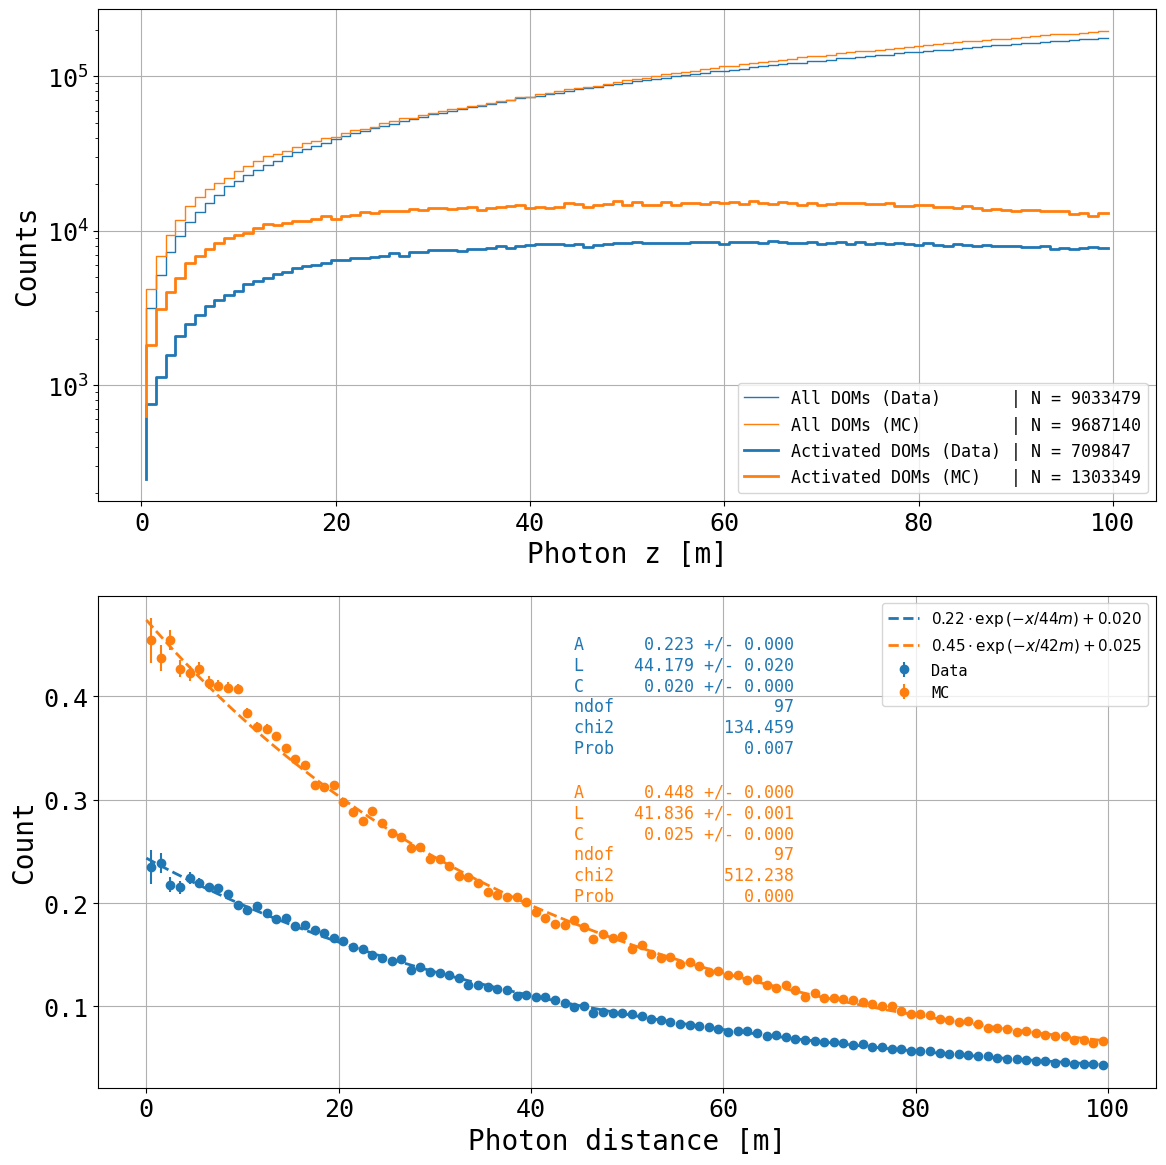

In [13]:
def exponential(x, A, L, C):
        return A * np.exp(-x/L) + C

# Initial parameter 
A_init = 0.5
L_init = 40
C_init = 0.02

def fit_exp(y_data, y_err):
    def chi_square(A, L, C):
        y_model = exponential(x_data, A, L, C)
        return np.sum(((y_data - y_model) / np.array(y_err))**2)
    
    minuit = Minuit(chi_square, A=A_init, L=L_init, C=C_init)
    minuit.migrad()
    chi2_value = minuit.fval
    dof = len(y_data) - len(minuit.values)
    p_value = 1.0 - chi2.cdf(chi2_value, dof)
    d  = {
        'A':   [minuit.values['A'], minuit.errors['A']],
        'L':   [minuit.values['L'], minuit.errors['L']],
        'C':   [minuit.values['C'], minuit.errors['C']],
        'ndof': dof,
        'chi2': chi2_value,
        'Prob': p_value,
#        'Conv': minuit.valid
        }
    print(minuit.valid * 'Fit has converged.' + (1-minuit.valid) * 'WARNING: Fit did not converge.')

    return d

rd_d  = fit_exp(rdeff,  rdeff_err)
mc_d  = fit_exp(mceff,  mceff_err)
mct_d = fit_exp(mcteff, mcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
#fig.suptitle('Weighted with charge', fontsize=20)
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Counts', yscale='log')
ax[0].grid()

nmin = 50
c1, c2, c3 = 'C00', 'C01', 'black'
fs = 12
X = bin_centers
X2 = np.linspace(RANGE[0], RANGE[1], 200)
ax[1].errorbar(X, rdeff,  yerr=rdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, mceff,  yerr=mceff_err, color=c2, fmt ='o', label='MC')
#ax[1].errorbar(X, mcteff, yerr=mcteff_err, color=c3, fmt ='o', label='Truth')

d = rd_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.92, text, ax[1], fontsize=fs, color=c1)

d = mc_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.62, text, ax[1], fontsize=fs, color=c2)

#d = mct_d
#ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
#text = nice_string_output(d, extra_spacing=2, decimals=3)
#add_text_to_ax(0.75, 0.62, text, ax[1], fontsize=fs, color=c3)

ax[1].set(xlabel = 'Photon distance [m]', ylabel = 'Count')
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
#plt.savefig('plots/photon_distance_without_charge_efficiency.pdf')
plt.show()

In [14]:
nbins

100

Fit has converged.
Fit has converged.


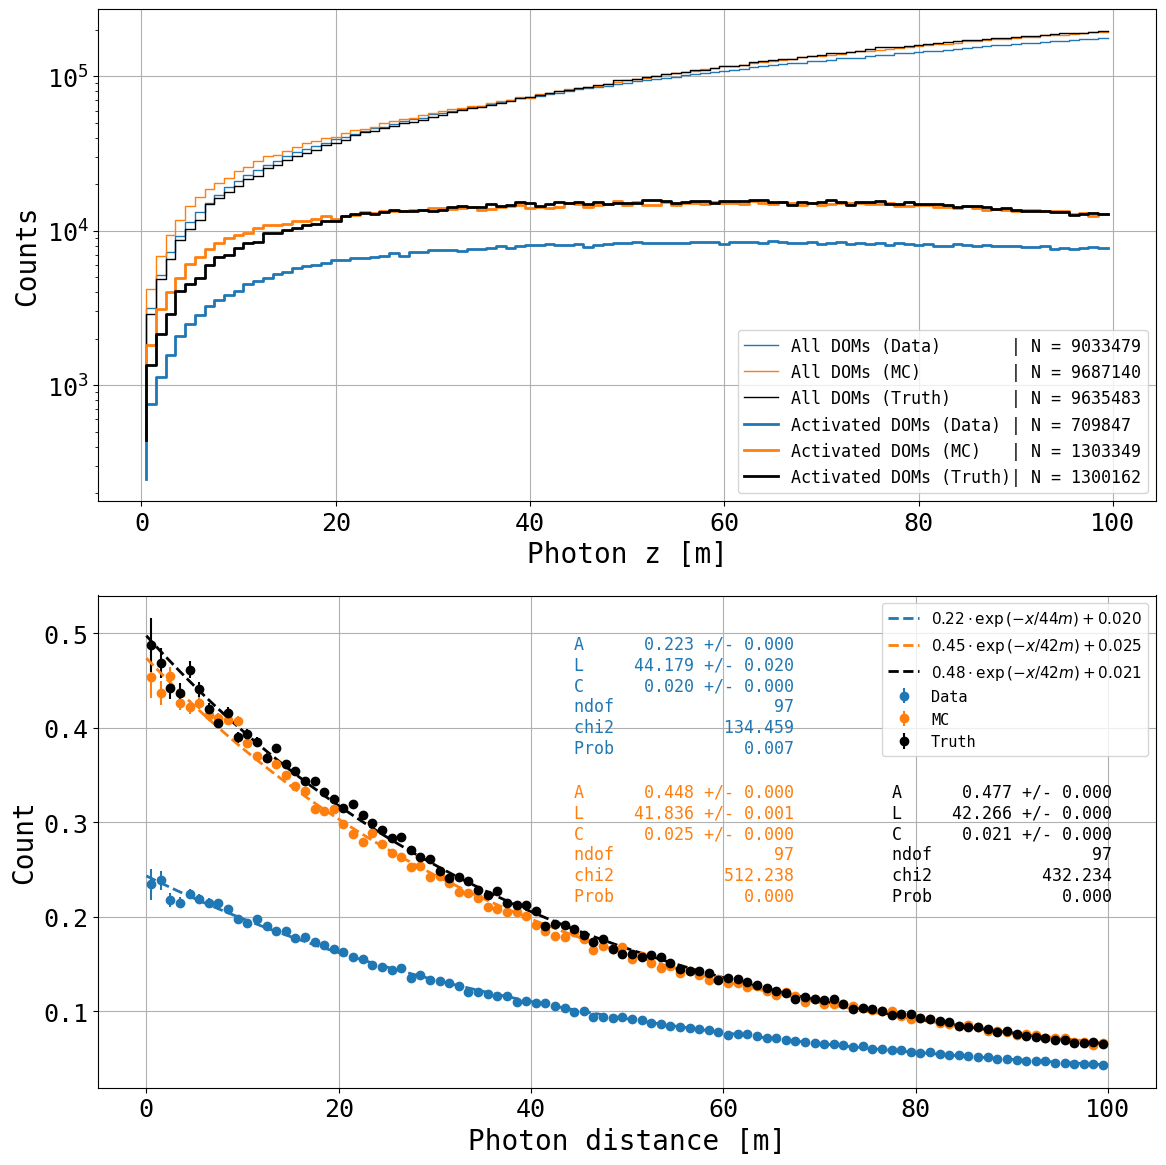

In [20]:
rd_d  = fit_exp(rdeff,  rdeff_err)
mc_d  = fit_exp(mceff,  mceff_err)
mct_d = fit_exp(mcteff, mcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
#fig.suptitle('Weighted with charge', fontsize=20)
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Counts', yscale='log')
ax[0].grid()

nmin = 50
c1, c2, c3 = 'C00', 'C01', 'black'
fs = 12
X = bin_centers
ax[1].errorbar(X, rdeff,  yerr=rdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, mceff,  yerr=mceff_err, color=c2, fmt ='o', label='MC')
ax[1].errorbar(X, mcteff, yerr=mcteff_err, color=c3, fmt ='o', label='Truth')

d = rd_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.92, text, ax[1], fontsize=fs, color=c1)

d = mc_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.62, text, ax[1], fontsize=fs, color=c2)

d = mct_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.75, 0.62, text, ax[1], fontsize=fs, color=c3)

ax[1].set(xlabel = 'Photon distance [m]', ylabel = 'Count')
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/photon_distance_without_charge_efficiency_vs_truth_100bins.pdf')
plt.show()

# With charge

Fit has converged.
Fit has converged.


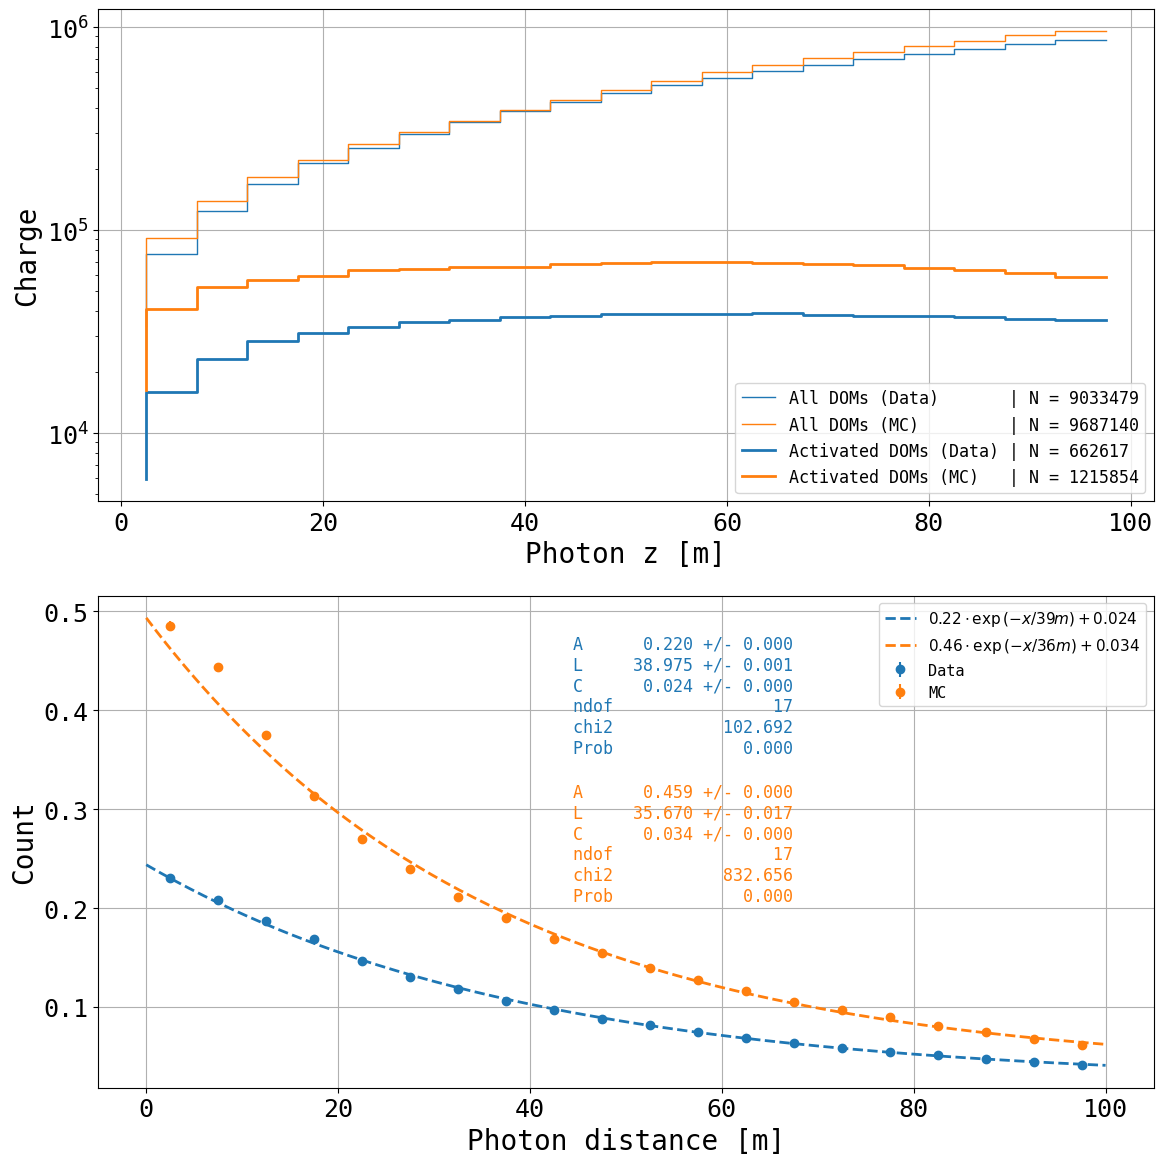

In [7]:
qrd_d  = fit_exp(qrdeff,  qrdeff_err)
qmc_d  = fit_exp(qmceff,  qmceff_err)
qmct_d = fit_exp(qmcteff, qmcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, qrd_activated, where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated, where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
#ax[0].step(bin_centers, qmct_activated,where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Charge', yscale='log')
ax[0].grid()

nmin = 50
c1, c2, c3 = 'C00', 'C01', 'black'
fs = 12
X = bin_centers
ax[1].errorbar(X, qrdeff,  yerr=qrdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, qmceff,  yerr=qmceff_err, color=c2, fmt ='o', label='MC')
#ax[1].errorbar(X, qmcteff, yerr=qmcteff_err, color=c3, fmt ='o', label='Truth')

d = qrd_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.92, text, ax[1], fontsize=fs, color=c1)

d = qmc_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.62, text, ax[1], fontsize=fs, color=c2)

#d = qmct_d
#ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
#text = nice_string_output(d, extra_spacing=2, decimals=3)
#add_text_to_ax(0.75, 0.62, text, ax[1], fontsize=fs, color=c3)

ax[1].set(xlabel = 'Photon distance [m]', ylabel = 'Count')
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/photon_distance_with_charge_efficiency.pdf')
plt.show()

Fit has converged.
Fit has converged.


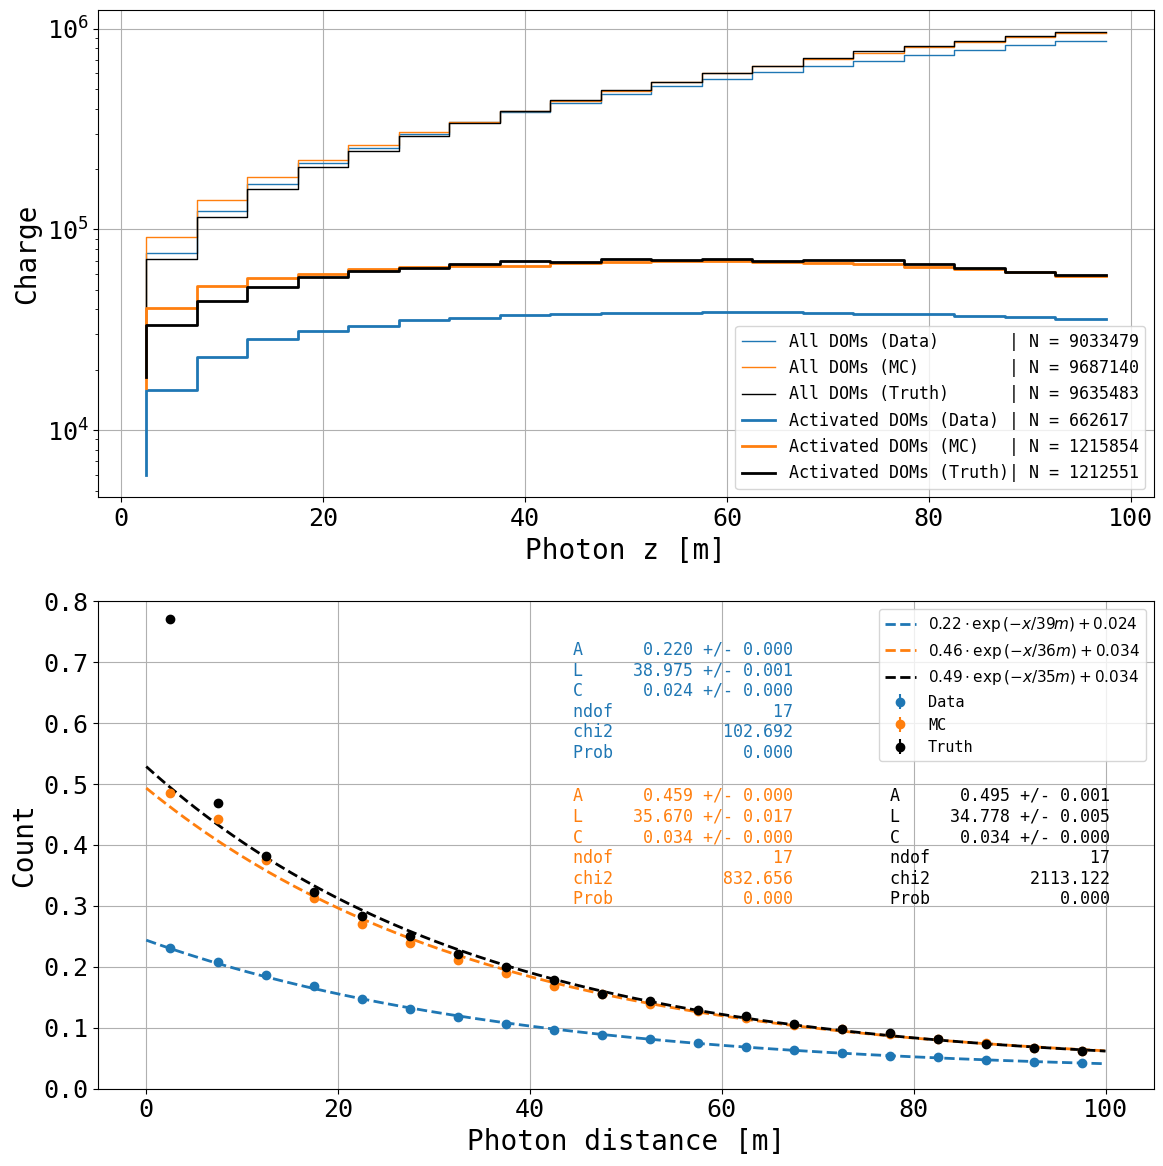

In [8]:
qrd_d  = fit_exp(qrdeff,  qrdeff_err)
qmc_d  = fit_exp(qmceff,  qmceff_err)
qmct_d = fit_exp(qmcteff, qmcteff_err)


hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, qrd_activated, where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated, where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
ax[0].step(bin_centers, qmct_activated,where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Charge', yscale='log')
ax[0].grid()

nmin = 50
c1, c2, c3 = 'C00', 'C01', 'black'
fs = 12
X = bin_centers
ax[1].errorbar(X, qrdeff,  yerr=qrdeff_err, color=c1, fmt ='o', label='Data')
ax[1].errorbar(X, qmceff,  yerr=qmceff_err, color=c2, fmt ='o', label='MC')
ax[1].errorbar(X, qmcteff, yerr=qmcteff_err, color=c3, fmt ='o', label='Truth')

d = qrd_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c1, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.92, text, ax[1], fontsize=fs, color=c1)

d = qmc_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c2, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.62, text, ax[1], fontsize=fs, color=c2)

d = qmct_d
ax[1].plot(X2, exponential(X2, d['A'][0], d['L'][0], d['C'][0]), linestyle='--', color=c3, linewidth=2, label=r'${:.2f}\cdot \exp\left(-x/{:.0f}m\right) + {:.3f}$'.format(d['A'][0], d['L'][0], d['C'][0]))
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.75, 0.62, text, ax[1], fontsize=fs, color=c3)

ax[1].set(xlabel = 'Photon distance [m]', ylabel = 'Count', ylim=(0,0.8))
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/photon_distance_with_charge_efficiency_vs_truth_cropped.pdf')
plt.show()